In [21]:
import numpy as np
from scipy import signal

def innerprod_psd(x_vec, y_vec, samp_freq, psd_vals):
    """
    P = INNERPROD_PSD(X, Y, Fs, Sn)
    
    Calculates the inner product of vectors X and Y for the case of Gaussian
    stationary noise having a specified power spectral density. Sn is a vector
    containing PSD values at the positive frequencies in the DFT of X
    and Y. The sampling frequency of X and Y is Fs.
    
    Parameters:
    -----------
    x_vec : array_like
        First input vector
    y_vec : array_like
        Second input vector
    samp_freq : float
        Sampling frequency of X and Y
    psd_vals : array_like
        PSD values at positive DFT frequencies
    
    Returns:
    --------
    inn_prod : float
        Inner product value
        
    Raises:
    -------
    ValueError
        If vectors are not the same length or PSD values don't match expected length
        
    """
    
    x_vec = np.array(x_vec)
    y_vec = np.array(y_vec)
    psd_vals = np.array(psd_vals)
    
    n_samples = len(x_vec)

    if len(y_vec) != n_samples:
        raise ValueError('Vectors must be of the same length')
    
    k_nyq = n_samples // 2 +1
    
    if len(psd_vals) != k_nyq:
        raise ValueError('PSD values must be specified at positive DFT frequencies')
    
    
    fft_x = np.fft.fft(x_vec)
    fft_y = np.fft.fft(y_vec)
        
    # We take care of even or odd number of samples when replicating PSD values
    # for negative frequencies
    neg_f_strt = 1 - (n_samples % 2) #even~1,odd~0
    psd_vec_4_norm = np.concatenate([psd_vals, psd_vals[( (k_nyq-1) - neg_f_strt):0:-1]])

    
    # print('fft_x shape:', fft_x.shape)
    # print('psd_vals shape:', psd_vals.shape)
    # print('psd_vec_4_norm shape:', psd_vec_4_norm.shape)
    # print('k_nyq:', k_nyq)
    
    data_len = samp_freq * n_samples #duration of the signal in seconds
    inn_prod = (1 / data_len) * np.sum((fft_x / psd_vec_4_norm) * np.conj(fft_y))
    inn_prod = np.real(inn_prod)
    
    return inn_prod

In [22]:
import numpy as np

def normsig4psd(sig_vec, samp_freq, psd_vec, snr):
    """
    Normalize a given signal to have a specified SNR in specified noise PSD
    
    Parameters:
    -----------
    sig_vec : array_like
        Signal vector to be normalized to have signal to noise ratio SNR
    samp_freq : float
        Sampling frequency
    psd_vec : array_like
        Noise PSD vector. Should be specified at the positive DFT frequencies 
        corresponding to the length of sig_vec and sampling frequency samp_freq
    snr : float
        Desired signal to noise ratio
        
    Returns:
    --------
    norm_sig_vec : ndarray
        Normalized signal vector
    norm_fac : float
        Normalization factor
        
    Notes:
    ------
    The PSD should be specified at the positive DFT frequencies corresponding 
    to the length of sig_vec and sampling frequency samp_freq. The normalized 
    signal vector is returned along with the normalization factor.
    
    """
    
    # Convert inputs to numpy arrays
    sig_vec = np.asarray(sig_vec)
    psd_vec = np.asarray(psd_vec)
    
    # PSD length must be commensurate with the length of the signal DFT
    n_samples = len(sig_vec)
    k_nyq = n_samples // 2 +1
    
    if len(psd_vec) != k_nyq:
        raise ValueError('Length of PSD is not correct')
    
    # Norm of signal squared is inner product of signal with itself
    norm_sig_sqrd = innerprod_psd(sig_vec, sig_vec, samp_freq, psd_vec)
    
    # Normalization factor
    norm_fac = snr / np.sqrt(norm_sig_sqrd)
    
    # Normalize signal to specified SNR
    norm_sig_vec = norm_fac * sig_vec
    
    return norm_sig_vec, norm_fac

In [23]:
import numpy as np

def crcbgenqcsig(dataX, snr, qcCoefs):
    # Generate a quadratic chirp signal

    # Convert inputs to numpy arrays for element-wise operations
    dataX = np.array(dataX)
    qcCoefs = np.array(qcCoefs)
    
    # Calculate phase vector: a1*t + a2*t^2 + a3*t^3
    phaseVec = qcCoefs[0] * dataX + qcCoefs[1] * dataX**2 + qcCoefs[2] * dataX**3
    
    # Generate the signal using sine function
    sigVec = np.sin(2 * np.pi * phaseVec)
    
    # Normalize and scale by SNR
    sigVec = snr * sigVec / np.linalg.norm(sigVec)
    
    return sigVec

def statgaussnoisegen(n_samples, psd_vals, fltr_order, samp_freq):
    #Generate a realization of stationary Gaussian noise with given 2-sided PSD
    
    # Design FIR filter with T(f) = square root of target PSD
    freq_vec = psd_vals[:, 0]
    sqrt_psd = np.sqrt(psd_vals[:, 1])

    
    # Design FIR filter using firwin2 
    b = signal.firwin2(fltr_order + 1, freq_vec, sqrt_psd, fs=samp_freq)
    
    # Generate white Gaussian noise realization
    in_noise = np.random.randn(n_samples)
    
    # Pass through the designed filter and scale
    out_noise = np.sqrt(samp_freq) * signal.fftconvolve(in_noise,b, mode='same')
    return out_noise




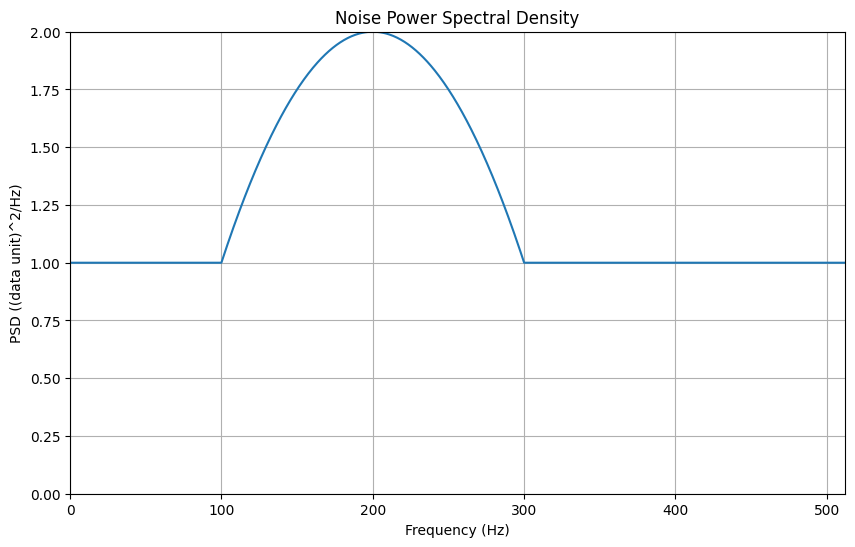

Generating H0 data...
Generating H1 data...


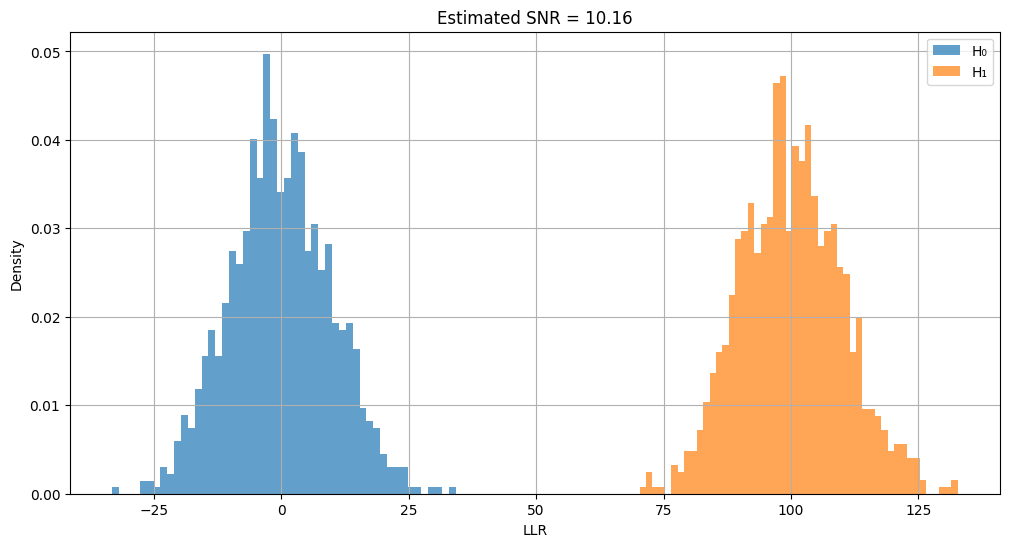

Target SNR: 10
Estimated SNR: 10.16
Mean LLR H0: -0.1663
Mean LLR H1: 100.1224
Std LLR H0: 9.8699


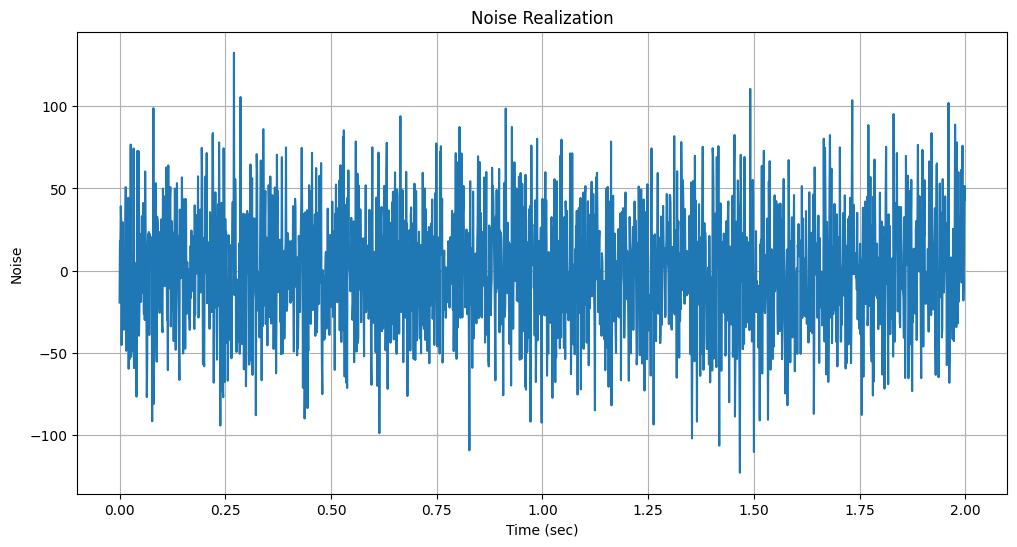

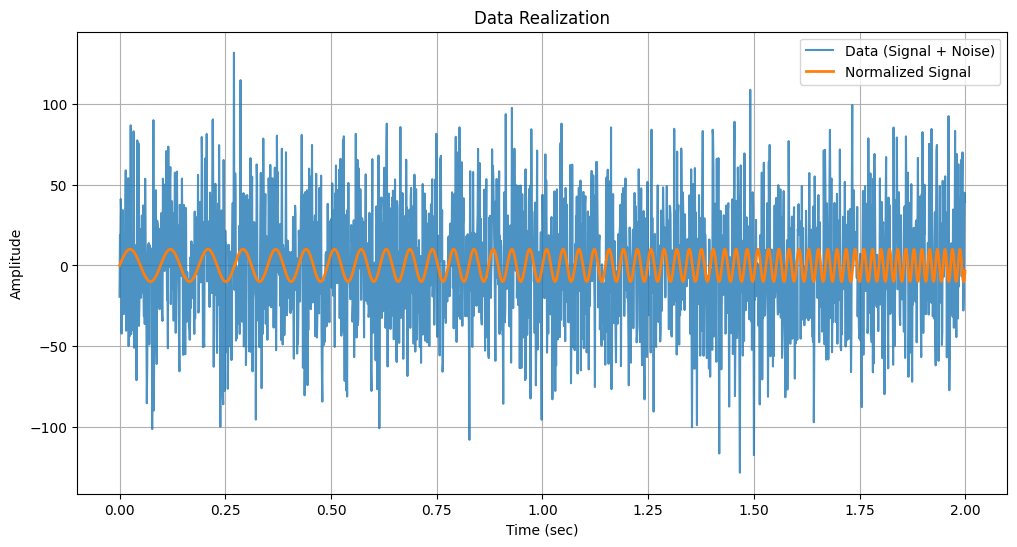

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Demo for estimating the SNR of the LR test (binary hypotheses) from multiple data realizations

# Target SNR for the LR
snr = 10

# Data generation parameters
n_samples = 2048
samp_freq = 1024
time_vec = np.arange(n_samples) / samp_freq

# Generate the signal that is to be normalized
a1, a2, a3 = 10, 3, 3
A = 1  # Amplitude value does not matter as it will be changed in normalization
sig_vec = crcbgenqcsig(time_vec, A, [a1, a2, a3])

# Define noise PSD function
def noise_psd(f):
    return ((f >= 100) & (f <= 300)) * (f - 100) * (300 - f) / 10000 + 1

# Generate the PSD vector for normalization
data_len = n_samples / samp_freq
k_nyq = n_samples // 2 +1
pos_freq = np.arange(k_nyq) / data_len
psd_pos_freq = noise_psd(pos_freq)

# Plot PSD
plt.figure(figsize=(10, 6))
plt.plot(pos_freq, psd_pos_freq)
plt.xlim(0, pos_freq[-1])
plt.ylim(0, np.max(psd_pos_freq))
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ((data unit)^2/Hz)')
plt.title('Noise Power Spectral Density')
plt.grid(True)
plt.show()

# Calculation of the norm
# Norm of signal squared is inner product of signal with itself
# print('signal_vec shape:', sig_vec.shape)
norm_sig_sqrd = innerprod_psd(sig_vec, sig_vec, samp_freq, psd_pos_freq)
# print(f"Signal norm squared: {norm_sig_sqrd}")

# Normalize signal to specified SNR
sig_vec = snr * sig_vec / np.sqrt(norm_sig_sqrd)
# print(f"Signal normalized to SNR: {snr}")

# Test: Obtain LLR values for multiple noise realizations (H0)
n_h0_data = 1000
llr_h0 = np.zeros(n_h0_data)

print("Generating H0 data...")
for lp in range(n_h0_data):
    noise_vec = statgaussnoisegen(n_samples, np.column_stack([pos_freq, psd_pos_freq]), 100, samp_freq)
    llr_h0[lp] = innerprod_psd(noise_vec, sig_vec, samp_freq, psd_pos_freq)

# Obtain LLR for multiple data (signal + noise) realizations (H1)
n_h1_data = 1000
llr_h1 = np.zeros(n_h1_data)

print("Generating H1 data...")
for lp in range(n_h1_data):
    noise_vec = statgaussnoisegen(n_samples, np.column_stack([pos_freq, psd_pos_freq]), 200, samp_freq)
    # Add normalized signal
    data_vec = noise_vec + sig_vec
    llr_h1[lp] = innerprod_psd(data_vec, sig_vec, samp_freq, psd_pos_freq)

# Signal to noise ratio estimate
est_snr = (np.mean(llr_h1) - np.mean(llr_h0)) / np.std(llr_h0)

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(llr_h0, bins=50, alpha=0.7, label='H₀', density=True)
plt.hist(llr_h1, bins=50, alpha=0.7, label='H₁', density=True)
plt.xlabel('LLR')
plt.ylabel('Density')
plt.legend()
plt.title(f'Estimated SNR = {est_snr:.2f}')
plt.grid(True)
plt.show()

print(f"Target SNR: {snr}")
print(f"Estimated SNR: {est_snr:.2f}")
print(f"Mean LLR H0: {np.mean(llr_h0):.4f}")
print(f"Mean LLR H1: {np.mean(llr_h1):.4f}")
print(f"Std LLR H0: {np.std(llr_h0):.4f}")

# Plot a noise realization
plt.figure(figsize=(12, 6))
plt.plot(time_vec, noise_vec)
plt.xlabel('Time (sec)')
plt.ylabel('Noise')
plt.title('Noise Realization')
plt.grid(True)
plt.show()

# Plot a data realization
plt.figure(figsize=(12, 6))
plt.plot(time_vec, data_vec, label='Data (Signal + Noise)', alpha=0.8)
plt.plot(time_vec, sig_vec, label='Normalized Signal', linewidth=2)
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.title('Data Realization')
plt.legend()
plt.grid(True)
plt.show()

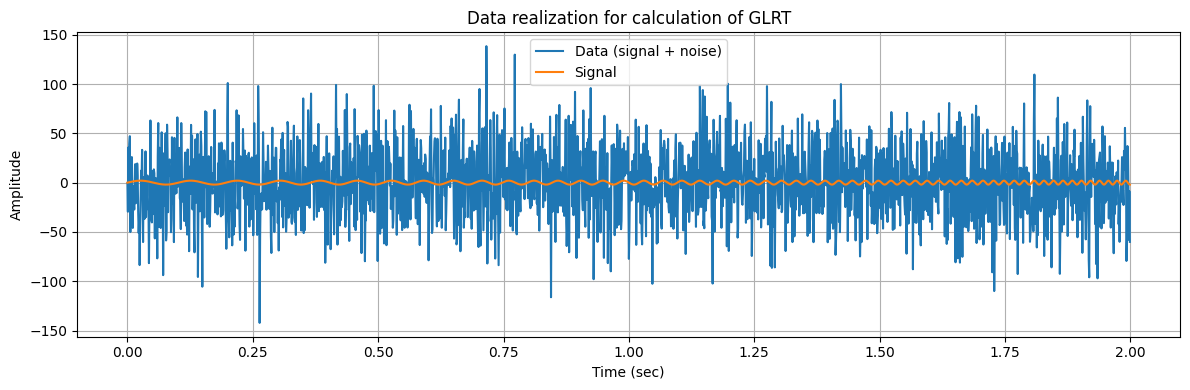

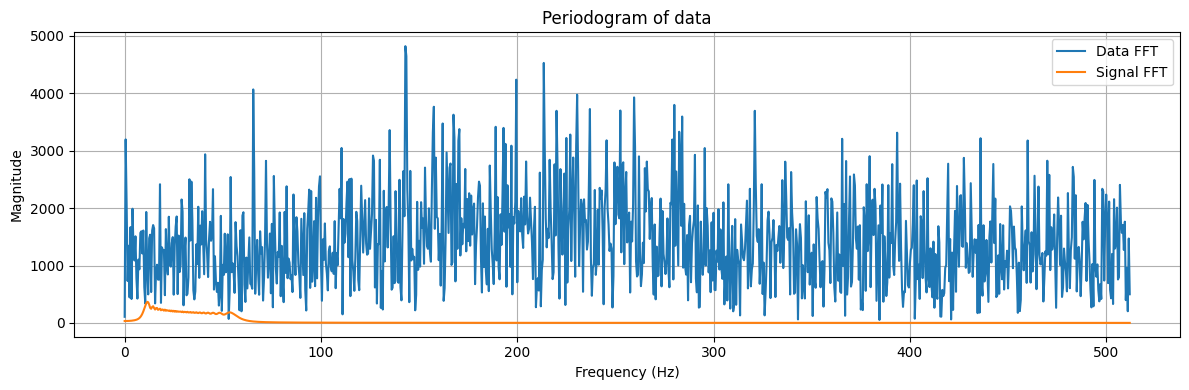

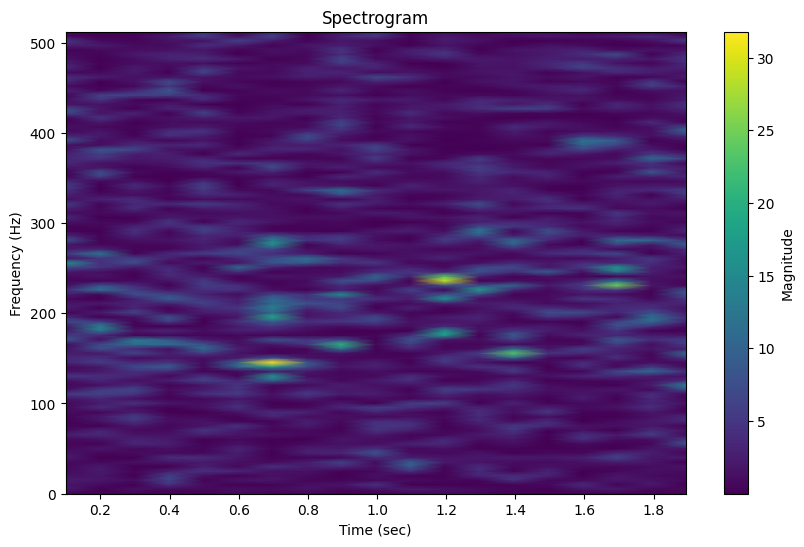

GLRT value: 4.5850


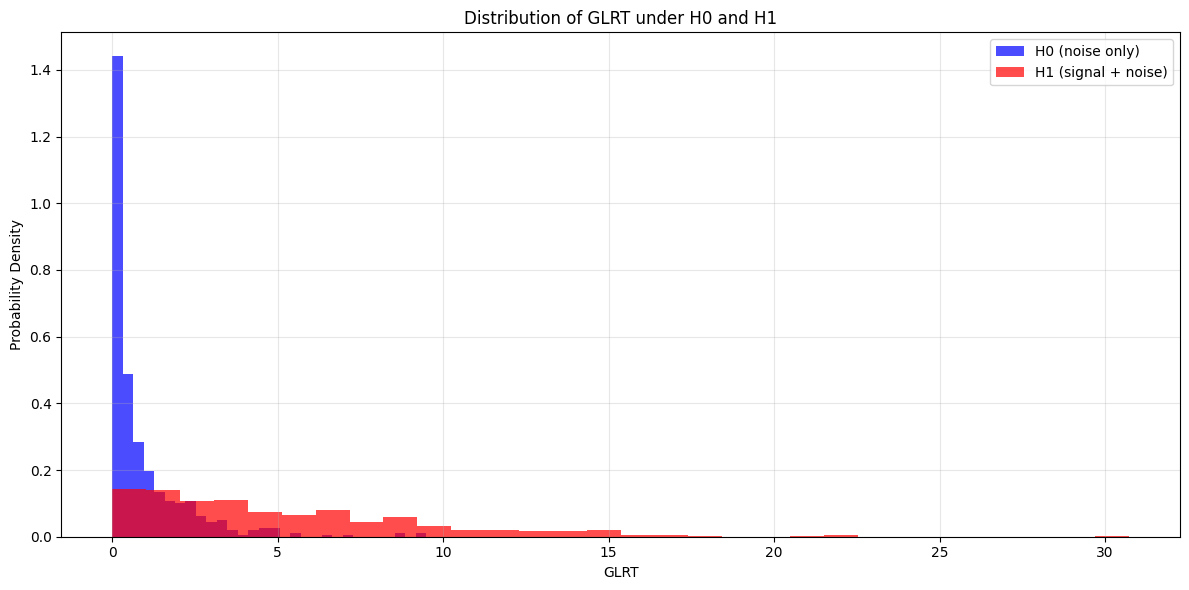

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')


## Demo for calculating the GLRT when only the amplitude is unknown

# Parameters for data realization
nSamples = 2048
sampFreq = 1024
timeVec = np.arange(nSamples) / sampFreq

# Supply PSD values
def noisePSD(f):
    """Noise power spectral density function"""
    return ((f >= 100) & (f <= 300)) * (f - 100) * (300 - f) / 10000 + 1

dataLen = nSamples / sampFreq
kNyq = nSamples // 2 + 1
posFreq = np.arange(kNyq) / dataLen
psdPosFreq = noisePSD(posFreq)

# Generate data realization
# Parameters of the signal to be injected
a1 = 9.5
a2 = 2.8
a3 = 3.2
A = 2  # SNR

# Generate signal with arbitrary amplitude
sig4data = crcbgenqcsig(timeVec, 1, [a1, a2, a3])

# Normalize signal to SNR = A in noise with specified PSD
sig4data, _ = normsig4psd(sig4data, sampFreq, psdPosFreq, A)

# Generate noise realization
noiseVec = statgaussnoisegen(nSamples, np.column_stack([posFreq, psdPosFreq]), 100, sampFreq)

# Data realization = noise + signal
dataVec = noiseVec + sig4data

# Plot time domain data
plt.figure(figsize=(12, 4))
plt.plot(timeVec, dataVec, label='Data (signal + noise)')
plt.plot(timeVec, sig4data, label='Signal')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.title('Data realization for calculation of GLRT')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot frequency domain
plt.figure(figsize=(12, 4))
datFFT = np.abs(fft(dataVec))
sigFFT = np.abs(fft(sig4data))
plt.plot(posFreq, datFFT[:kNyq], label='Data FFT')
plt.plot(posFreq, sigFFT[:kNyq], label='Signal FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Periodogram of data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# # Spectrogram
# plt.figure(figsize=(12, 6))
# f, t, Sxx = signal.spectrogram(dataVec, sampFreq, nperseg=64, noverlap=50)
# plt.pcolormesh(t, f, np.abs(Sxx))
# plt.ylabel('Frequency (Hz)')
# plt.xlabel('Time (sec)')
# plt.title('Spectrogram')
# plt.colorbar()
# plt.tight_layout()
# plt.show()

# Compute the spectrogram and plot
# winLen = 0.1  # sec
# ovrlp = 0.08 # sec
winLen = 0.2  # sec
ovrlp = 0.1 # sec
winLenSmpls = int(np.floor(winLen * sampFreq))# Convert to integer number of samples
ovrlpSmpls = int(np.floor(ovrlp * sampFreq))
f, t, Sxx = signal.spectrogram(dataVec, fs=sampFreq, window='hann', nperseg=winLenSmpls, noverlap=ovrlpSmpls)
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, np.abs(Sxx), shading='gouraud')
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.colorbar(label='Magnitude')
plt.show()

# Compute GLRT
# Generate unit norm template
sigVec = crcbgenqcsig(timeVec, 1, [a1, a2, a3])
templateVec, _ = normsig4psd(sigVec, sampFreq, psdPosFreq, 1)

# Calculate inner product of data with unit norm template
llr = innerprod_psd(dataVec, templateVec, sampFreq, psdPosFreq)

# GLRT is the square of the log-likelihood ratio
glrt_value = llr**2
print(f"GLRT value: {glrt_value:.4f}")

# Estimate distribution of GLRT under null and alternative hypotheses
nRlz = 500  # Number of realizations
glrtH0 = np.zeros(nRlz)  # Null hypothesis (noise only)
glrtH1 = np.zeros(nRlz)  # Alternative hypothesis (signal + noise)

# Set random seed for reproducibility
np.random.seed(42)

# Calculate GLRT under null hypothesis (noise only)
for i in range(nRlz):
    
    # Generate noise realization
    noiseVec = statgaussnoisegen(nSamples, np.column_stack([posFreq, psdPosFreq]), 100, sampFreq)
    
    # Compute GLRT
    llr = innerprod_psd(noiseVec, templateVec, sampFreq, psdPosFreq)
    glrtH0[i] = llr**2

# Calculate GLRT under alternative hypothesis (signal + noise)
for i in range(nRlz):
    
    # Generate noise realization
    noiseVec = statgaussnoisegen(nSamples, np.column_stack([posFreq, psdPosFreq]),100, sampFreq)
    
    # Add signal
    dataVec_sim = noiseVec + sig4data
    
    # Compute GLRT
    llr = innerprod_psd(dataVec_sim, templateVec, sampFreq, psdPosFreq)
    glrtH1[i] = llr**2

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(glrtH0, bins=30, alpha=0.7, density=True, label='H0 (noise only)', color='blue')
plt.hist(glrtH1, bins=30, alpha=0.7, density=True, label='H1 (signal + noise)', color='red')
plt.xlabel('GLRT')
plt.ylabel('Probability Density')
plt.title('Distribution of GLRT under H0 and H1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



# # Print statistics
# print(f"\nStatistics:")
# print(f"H0 (noise only):")
# print(f"  Mean: {np.mean(glrtH0):.4f}")
# print(f"  Std:  {np.std(glrtH0):.4f}")
# print(f"H1 (signal + noise):")
# print(f"  Mean: {np.mean(glrtH1):.4f}")
# print(f"  Std:  {np.std(glrtH1):.4f}")
